1. Jak zachowują się sklepy pod względem zmian cen przed i po ważnym wydarzeniu
na rynku takim jak na przykład Black Friday?

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Wczytanie danych
df = pd.read_csv('monitoring_cen.csv')
df['Data'] = pd.to_datetime(df['Data'])

# Funkcja badająca otoczenie wprowadzanej daty
def calculate_averange_price(df, enter_date):

    # Konwersja daty wejściowej na format datetime
    enter_date = pd.to_datetime(enter_date)

    # Obliczenie zakresów dat
    range_1 = (enter_date - pd.DateOffset(months=2), enter_date - pd.DateOffset(months=1))
    range_2 = (enter_date - pd.DateOffset(months=1), enter_date)
    range_3 = (enter_date, enter_date + pd.DateOffset(months=1))

    # Okres 3 miesięcy do obliczania dostępności
    range_3_months = (enter_date - pd.DateOffset(months=2), enter_date + pd.DateOffset(months=1))
    filtr_3_months = (df['Data'] >= range_3_months[0]) & (df['Data'] < range_3_months[1])
    df_period_3_months = df[filtr_3_months]

    # Okres +/- 3 dni od wskazanej daty
    range_7_days = (enter_date - pd.Timedelta(days=3), enter_date + pd.Timedelta(days=3))
    filtr_7_days = (df['Data'] >= range_7_days[0]) & (df['Data'] <= range_7_days[1])
    df_period_7_days = df[filtr_7_days]

    # Obliczenie dostępności produktów w okresie 3 miesięcy
    availability = df_period_3_months.groupby(['Nazwa urzadzenia', 'Sklep'])['Czy dostepny'].mean().unstack()

    # Sprawdzenie dostępności produktów w okresie +/- 3 dni od wskazanej daty
    availability_in_7_days = (
        df_period_7_days.groupby(['Nazwa urzadzenia', 'Sklep'])['Czy dostepny']
        .apply(lambda x: x[x.index.isin(pd.date_range(range_7_days[0], range_7_days[1]))].all())
        .unstack()
    )

    # Wybranie produktów z dostępnością minimum 85% w okresie 3 miesięcy i spełniających warunek dostępności przez 3 dni przed/po i w trakcie wskazanej daty
    filtered_products = availability[
        (availability.min(axis=1) > 0.85) &
        (availability_in_7_days.all(axis=1))
    ].index


    # Funkcja pomocnicza do obliczania średnich cen tylko dla wybranych produktów
    def averange(df, start_date, end_date):
        filtr = (df['Data'] >= start_date) & (df['Data'] < end_date)
        df_period = df[filtr & df['Nazwa urzadzenia'].isin(filtered_products)]
        return df_period.groupby('Sklep')['Cena (zł)'].mean().round(2).to_dict()


    # Obliczenie średnich cen dla każdego zakresu dat
    results = {
        f"Zakres 1 ({range_1[0].date()} - {range_1[1].date()})": averange(df, * range_1),
        f"Zakres 2 ({range_2[0].date()} - {range_2[1].date()})": averange(df, * range_2),
        f"Zakres 3 ({range_3[0].date()} - {range_3[1].date()})": averange(df, * range_3),
    }

    # Zakresy dla dni przed i po wprowadzonej dacie
    days_before_after = [-3, -2, -1, 0, 1, 2, 3]
    for day in days_before_after:
        data_start = enter_date + pd.DateOffset(days=day)
        data_end = data_start + pd.DateOffset(days=1)
        results[f"Dzień {day} ({data_start.date()})"] = averange(df, data_start, data_end)


    # Konwersja wyników na DataFrame
    results_df = pd.DataFrame(results).stack().reset_index()
    results_df.columns = ['Sklep', 'Okres', 'Średnia Cena']

    # Podział danych na grupy
    results_months = results_df[results_df['Okres'].str.contains('Zakres')]
    results_days = results_df[results_df['Okres'].str.contains('Dzień')]

    # Wykres dla miesięcy
    plt.figure(figsize=(12, 6))
    sns.barplot(data=results_months, x='Sklep', y='Średnia Cena', hue='Okres', palette='colorblind')
    plt.ylabel('Średnia Cena (zł)')
    plt.xlabel('Okres')
    #plt.title('Średnia cena w różnych okresach miesięcznych przed i po Black Friday')
    plt.legend(title='Sklep', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Wykres dla dni
    plt.figure(figsize=(12, 6))
    sns.barplot(data=results_days, x='Sklep', y='Średnia Cena', hue='Okres', palette='colorblind')
    plt.ylabel('Średnia Cena (zł)')
    plt.xlabel('Dzień')
    #plt.title('Średnia cena w różnych dniach przed, w trakcie i po Black Friday')
    plt.legend(title='Sklep', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    return results_df, filtered_products.tolist(), len(filtered_products.tolist())

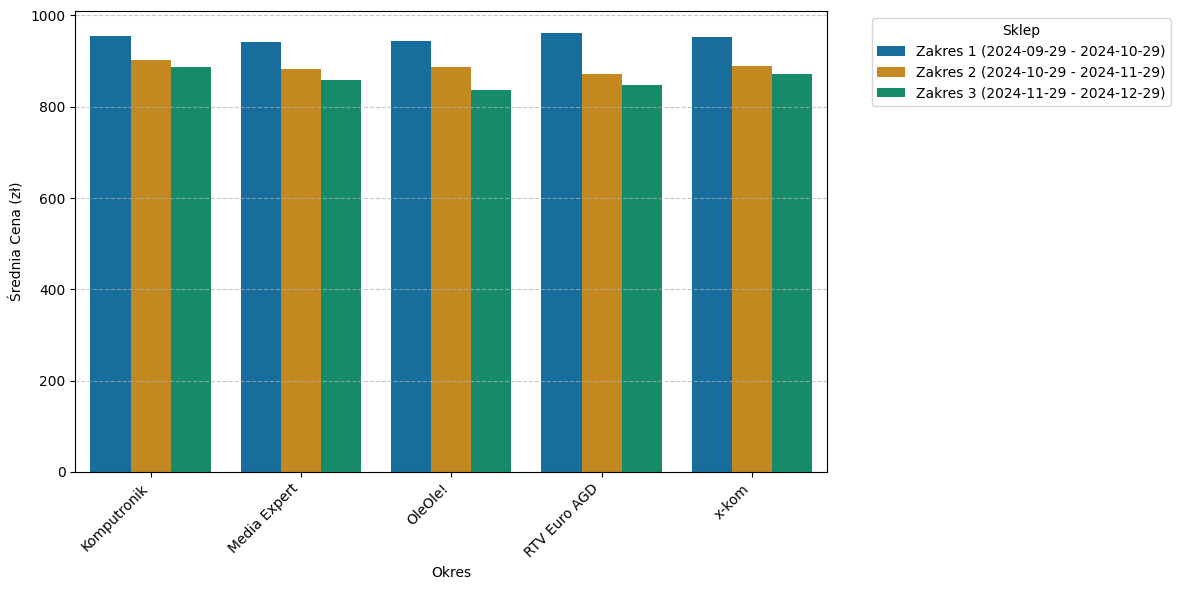

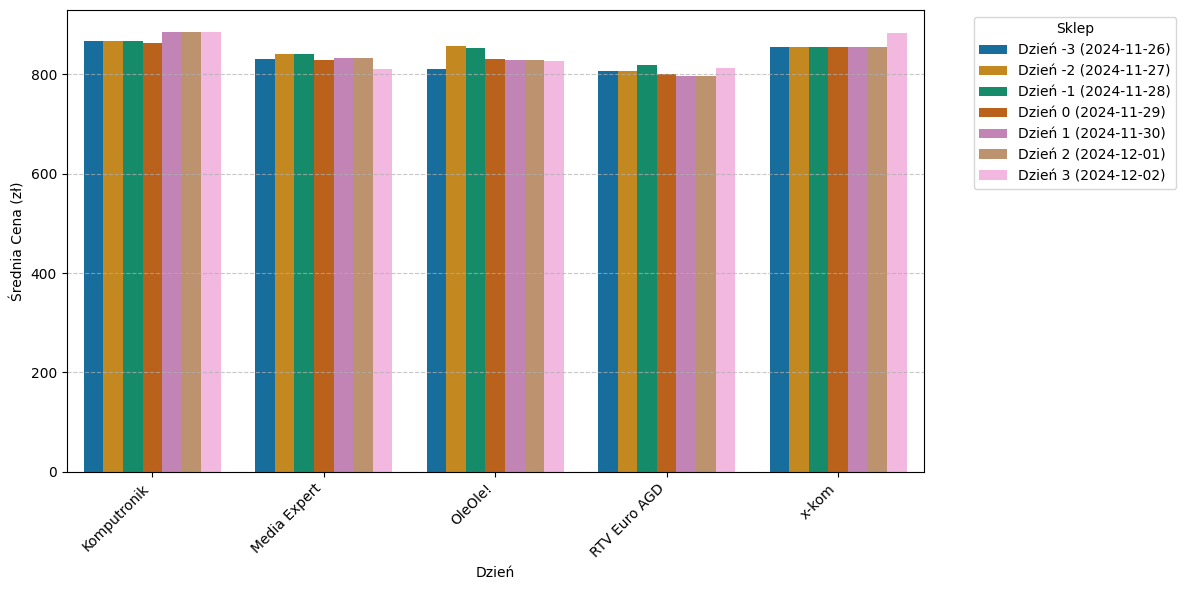

(           Sklep                               Okres  Średnia Cena
0    Komputronik  Zakres 1 (2024-09-29 - 2024-10-29)        954.13
1    Komputronik  Zakres 2 (2024-10-29 - 2024-11-29)        901.65
2    Komputronik  Zakres 3 (2024-11-29 - 2024-12-29)        887.06
3    Komputronik               Dzień -3 (2024-11-26)        868.00
4    Komputronik               Dzień -2 (2024-11-27)        868.00
5    Komputronik               Dzień -1 (2024-11-28)        867.44
6    Komputronik                Dzień 0 (2024-11-29)        863.11
7    Komputronik                Dzień 1 (2024-11-30)        885.33
8    Komputronik                Dzień 2 (2024-12-01)        885.33
9    Komputronik                Dzień 3 (2024-12-02)        885.33
10  Media Expert  Zakres 1 (2024-09-29 - 2024-10-29)        942.63
11  Media Expert  Zakres 2 (2024-10-29 - 2024-11-29)        883.26
12  Media Expert  Zakres 3 (2024-11-29 - 2024-12-29)        857.76
13  Media Expert               Dzień -3 (2024-11-26)        8

In [3]:
# Uruchomienie funkcji
result_df = calculate_averange_price(df, '2024-11-29')
print(result_df)

2. Który sklep zmienia ceny z największą częstotliwością i czy są to znaczące zmiany?

            Sklep                                   Nazwa urzadzenia  \
3     Komputronik                                Apple AirPods 4 gen   
4     Komputronik  Apple AirPods 4 gen ANC (z aktywną redukcją ha...   
5     Komputronik                    Apple AirPods Pro 2 gen MagSafe   
11    Komputronik                       LG UltraGear 27GS85Q-B - 27"   
12    Komputronik             Lenovo TAB P11 2 gen (TB350FU) 6/128GB   
14    Komputronik                              Samsung Galaxy Buds 3   
15    Komputronik                 Samsung Galaxy Tab A9 (X110) 128GB   
18    Komputronik                                   Sony WHCH720 ANC   
21    Komputronik                                  Xiaomi A27i - 27"   
28   Media Expert                                Apple AirPods 4 gen   
29   Media Expert  Apple AirPods 4 gen ANC (z aktywną redukcją ha...   
30   Media Expert                    Apple AirPods Pro 2 gen MagSafe   
36   Media Expert                       LG UltraGear 27GS85Q-B -

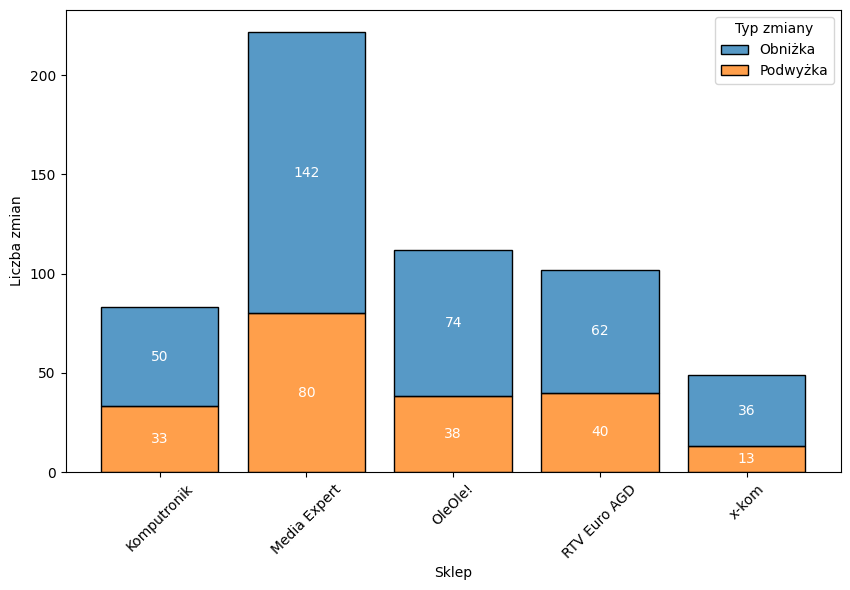

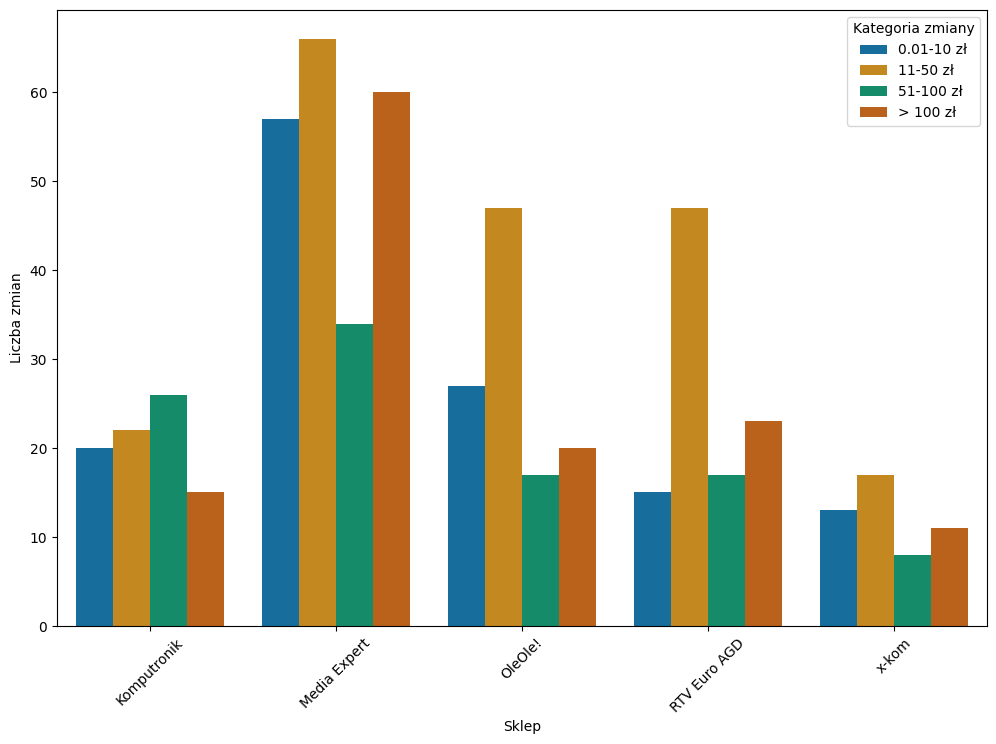

In [5]:
import pandas as pd

# Wczytanie danych
df = pd.read_csv('monitoring_cen.csv')
df['Data'] = pd.to_datetime(df['Data'])

# Obliczenie średniej dostępności
availability = df.groupby(['Sklep', 'Nazwa urzadzenia'])['Czy dostepny'].mean().reset_index()

# Sprawdzenie, które produkty mają co najmmniej 80% dostępności
availability_percent = availability.groupby('Nazwa urzadzenia').filter(lambda x: (x['Czy dostepny'] >= 0.8).all())

# Zliczenie produktów spełniających warunek
availability_percent_count = availability_percent.groupby('Sklep').size().reset_index(name='Liczba produktów >= 80% dostępności')

# Wyświetlenie liczby produktów w każdym sklepie
print(availability_percent)

# Wyszukanie tylko produktów, ktore były dostępne przez okreslony czas
df = pd.merge(df, availability_percent[['Sklep', 'Nazwa urzadzenia']], on=['Sklep', 'Nazwa urzadzenia'], how='inner')

# Sortowanie ramki danych według 'nazwa urzadzenia', 'sklep' i 'data'
df = df.sort_values(by=['Nazwa urzadzenia', 'Sklep', 'Data'])

# Różnica ceny dzień po dniu dla każdego produktu w sklepie
df['Zmiana ceny'] = df.groupby(['Sklep', 'Nazwa urzadzenia'])['Cena (zł)'].diff()

# Dodanie kolumny określającej typ zmiany ceny
df['Typ zmiany'] = df['Zmiana ceny'].apply(lambda x: 'Podwyżka' if x > 0 else ('Obniżka' if x < 0 else 'Brak zmiany'))

# Wykluczenie braku zmian cen
df = df[df['Typ zmiany'] != 'Brak zmiany']

# Pogrupowanie po typie zmiany
categories = df.groupby(['Sklep', 'Typ zmiany']).size().reset_index(name='Liczba zmian')

# Wykres słupkowy skumulowany
plt.figure(figsize=(10, 6))
ax = sns.histplot(data=categories, x='Sklep', hue='Typ zmiany', weights='Liczba zmian', multiple='stack', shrink=0.8)

# Dodawanie etykiet na środku segmentów słupków
for container in ax.containers:
    for bar in container:
        # Wysokość segmentu
        height = bar.get_height()
        # Dodawanie etykiet tylko dla widocznych segmentów
        if height > 0:
            # Obliczenie środka segmentu
            xpos = bar.get_x() + bar.get_width() / 2
            ypos = bar.get_y() + height / 2
            ax.text(xpos, ypos, f'{int(height)}', ha='center', va='center', fontsize=10, color='white')

#plt.title('Liczba podwyżek i obniżek w sklepach')
plt.xlabel('Sklep')
plt.ylabel('Liczba zmian')
plt.xticks(rotation=45)
plt.show()


# Dodanie kategorii wielkości zmian cen
# Funkcja dzieląca zmiany na kategorie
def change_category(change):
    if 0.01 <= abs(change) <= 10:
        return '0.01-10 zł'
    elif 11 <= abs(change) <= 50:
        return '11-50 zł'
    elif 51 <= abs(change) <= 100:
        return '51-100 zł'
    elif abs(change) > 100:
        return '> 100 zł'
    else:
        return None
    
# Przypisanie kategorii do zmian ceny
df['Kategoria zmiany'] = df['Zmiana ceny'].apply(change_category)

# Pogrupowanie po kategoriach
category = df.groupby(['Sklep', 'Kategoria zmiany']).size().reset_index(name='Liczba zmian')

# Stworzenie wykresu
plt.figure(figsize=(12, 8))
sns.barplot(data=category, x='Sklep', y='Liczba zmian', hue='Kategoria zmiany', palette='colorblind')
#plt.title('Liczba zmian cen w różnych kategoriach ich wielkości')
plt.xlabel('Sklep')
plt.ylabel('Liczba zmian')
plt.xticks(rotation=45)
plt.legend(title='Kategoria zmiany')
plt.show()



3. W jakie dni tygodnia sklepy najczęściej zmieniają swoje ceny w znaczący sposób
(minimum 10% ceny produktu)?

C:\Users\kryst\AppData\Local\Temp\ipykernel_19196\1100999832.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Dzień tygodnia'] = df_filtered['Data'].dt.strftime('%A')
C:\Users\kryst\AppData\Local\Temp\ipykernel_19196\1100999832.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Typ zmiany'] = df_filtered['Zmiana ceny'].apply(lambda x: 'Podwyżka' if x > 0 else 'Obniżka')


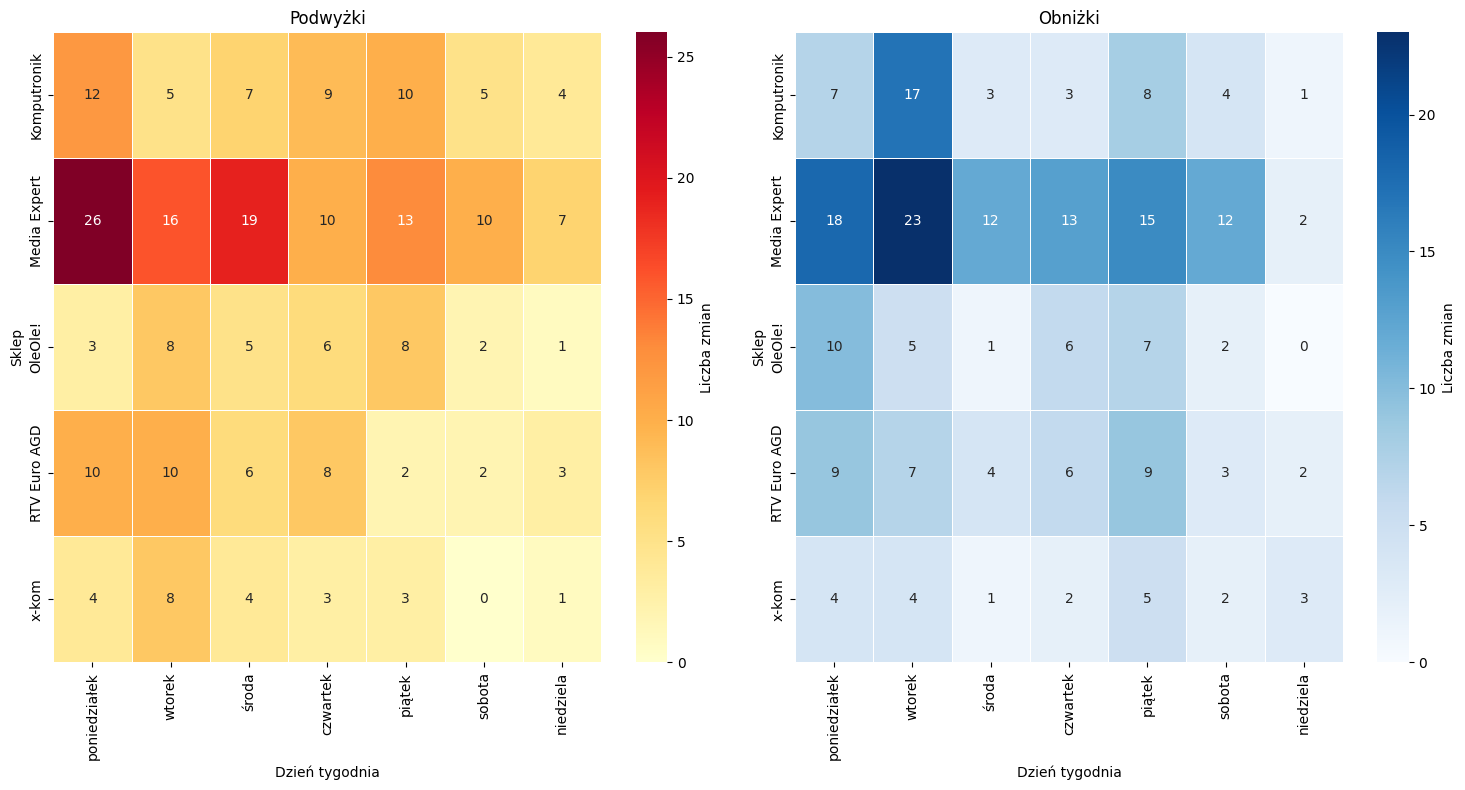

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import locale

# Wczytanie danych
df = pd.read_csv('monitoring_cen.csv')
df['Data'] = pd.to_datetime(df['Data'])

# Sortowanie danych
df = df.sort_values(by=['Nazwa urzadzenia', 'Sklep', 'Data'])

# Różnica dzień po dniu w cenie
df['Zmiana ceny'] = df.groupby(['Nazwa urzadzenia', 'Sklep'])['Cena (zł)'].diff()

# Zmiana cen wyrażona w procentach w odniesieniu do poprzedniej ceny
df['Zmiana procentowa'] = (df['Zmiana ceny'] / (df['Cena (zł)'] - df['Zmiana ceny']) * 100)

# Zmiany cen wynooszące co najmniej 10% ceny
df_filtered = df[df['Zmiana procentowa'].abs() >= 10]

# Ustawienie lokalizacji na Polskę
locale.setlocale(locale.LC_TIME, 'pl_PL')

# Dodanie kolumny z dniem tygodnia
df_filtered['Dzień tygodnia'] = df_filtered['Data'].dt.strftime('%A')

# Dodanie kolumny z typem zmiany
df_filtered['Typ zmiany'] = df_filtered['Zmiana ceny'].apply(lambda x: 'Podwyżka' if x > 0 else 'Obniżka')

# Ustalenie prawidłowej kolejności dni tygodnia
order_of_days = ['poniedziałek', 'wtorek', 'środa', 'czwartek', 'piątek', 'sobota', 'niedziela']

# Tabele przestawne dla podwyżek i obniżek
pivot_increase = df_filtered[df_filtered['Typ zmiany'] == 'Podwyżka'].pivot_table(index = 'Sklep', columns = 'Dzień tygodnia', values = 'Typ zmiany', aggfunc = 'count')
pivot_discount = df_filtered[df_filtered['Typ zmiany'] == 'Obniżka'].pivot_table(index = 'Sklep', columns = 'Dzień tygodnia', values = 'Typ zmiany', aggfunc = 'count')

# Zamiana na ramkę dancyh i wypełnienie brakujących pól 0
pivot_increase = pivot_increase.reindex(columns = order_of_days, fill_value = 0)
pivot_discount = pivot_discount.reindex(columns = order_of_days, fill_value = 0)

# przekonwertowanie pustych wartości na 0
pivot_increase = pivot_increase.fillna(0)
pivot_discount = pivot_discount.fillna(0)

# Zamiana na liczby całkowite
pivot_increase = pivot_increase.astype(int)
pivot_discount = pivot_discount.astype(int)

# Mapy ciepła
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Mapa ciepła dla podwyżek
sns.heatmap(pivot_increase, annot=True, cmap='YlOrRd', fmt='d', linewidths=0.5, cbar_kws={'label': 'Liczba zmian'}, annot_kws={'size': 10}, ax=axes[0])
axes[0].set_title('Podwyżki')
axes[0].set_xlabel('Dzień tygodnia')
axes[0].set_ylabel('Sklep')

# Mapa ciepła dla obniżek
sns.heatmap(pivot_discount, annot=True, cmap='Blues', fmt='d', linewidths=0.5, cbar_kws={'label': 'Liczba zmian'}, annot_kws={'size': 10}, ax=axes[1])
axes[1].set_title('Obniżki')
axes[1].set_xlabel('Dzień tygodnia')
axes[1].set_ylabel('Sklep')

plt.tight_layout()
plt.show()

4. Czy w obrębie konkurencji istnieje sklep, który jest inicjatorem zmian cen i inne
sklepy reagują za nim w ten sam sposób?

In [7]:
import pandas as pd
from datetime import timedelta

# Wczytanie danych
df = pd.read_csv('monitoring_cen.csv')
df['Data'] = pd.to_datetime(df['Data'])

# Sortowanie danych według 'nazwa urzadzenia', 'sklep' i 'data'
df = df.sort_values(by=['Nazwa urzadzenia', 'Sklep', 'Data'])

# Różnica ceny dzień po dniu dla każdego produktu w sklepie
df['Zmiana ceny'] = df.groupby(['Sklep', 'Nazwa urzadzenia'])['Cena (zł)'].diff()

# Dodanie kolumny z typem zmiany ceny
df['Typ zmiany'] = df['Zmiana ceny'].apply(lambda x: 'Podwyżka' if x > 0 else ('Obniżka' if x < 0 else 'Brak zmiany'))

# Sortowanie ramki danych według nazwy urządzenia i daty
df = df.sort_values(by=["Nazwa urzadzenia", "Data"], ascending=[True, True]).reset_index(drop=True)

# Dodanie kolumny z wyrażeniem zmiany ceny jako procent poprzedniej ceny
df['Zmiana procentowa'] = (df['Zmiana ceny'] / (df['Cena (zł)'] - df['Zmiana ceny']) * 100)

# zmiany cen wynooszące co najmniej 10% ceny
df = df[df['Zmiana procentowa'].abs() >= 10]

# Dodanie nowej kolumny dla statusu zmiany
df["Status zmiany"] = None

# Licznik iteracji
initiation_counter = 1

# Iteracja po unikalnych produktach
for product in df["Nazwa urzadzenia"].unique():
    # Filtrowanie ramki danych dla danego produktu
    product_data = df[df["Nazwa urzadzenia"] == product].sort_values(by="Data")
    # Zbiór indeksów już wykorzystanych jako reakcje
    reactions_used = set()  
    # Grupowanie zmian w tym samym dniu z tym samym typem zmiany
    grouped_data = product_data.groupby(["Data", "Typ zmiany"])
    
    for (data_zmiany, typ_zmiany), group in grouped_data:
        # Sklepy inicjujące tego samego dnia
        group_initiation = group.index.difference(reactions_used)
        if len(group_initiation) == 0:
            continue
        
        # wszystkie zmiany tego samego dnia jako inicjator
        for i in group_initiation:
            df.loc[i, "Status zmiany"] = f"inicjator_{initiation_counter}_{typ_zmiany}"
        
        # Reakcje w ciągu 2 dni
        two_days = product_data[
            (product_data["Data"] > data_zmiany) &
            (product_data["Data"] <= data_zmiany + timedelta(days=2)) &
            (product_data["Typ zmiany"] == typ_zmiany) &
            (~product_data.index.isin(reactions_used))  # Pomijanie już liczonych reakcji
        ]
        
        # Oznaczenie reakcji
        if len(two_days) > 0:
            for reaction_index in two_days.index:
                reaction_shop = product_data.loc[reaction_index, "Sklep"]
                # Pomijanie reakcji tego samego sklepu
                if reaction_shop not in group["Sklep"].values:  
                    df.loc[reaction_index, "Status zmiany"] = f"reakcja_{initiation_counter}_{typ_zmiany}"
                    reactions_used.add(reaction_index)
        
        # Zwiększenie liczniku inicjacji
        initiation_counter += 1


# Wiersze z inicjacjami
initiations = df[df['Status zmiany'].str.startswith('inicjator')]

# Wiersze z reakcjami
reactions = df[df['Status zmiany'].str.startswith('reakcja')]

# numery inicjacji, które mają reakcje
reactions['Numer inicjacji'] = reactions['Status zmiany'].str.extract(r'(\d+)')[0]
reactions_unique_shops = reactions.groupby('Numer inicjacji')['Sklep'].nunique()

# Filtrowanie inicjacji, które mają co najmniej 2 różne sklepy reagujące
initiations_2_reactions = reactions_unique_shops[reactions_unique_shops >= 2].index

# inicjacje, które mają reakcje i odpowiadające im numery - zmiana typu
initiations_2_reactions = initiations_2_reactions.astype(str)

# usuniecie inicjacji niespalniajacych warunkow
data_cleaned = df[~((df['Status zmiany'].str.startswith('inicjator')) &
                       (~df['Status zmiany'].str.extract(r'(\d+)')[0].isin(initiations_2_reactions)))]

# Usunięcie reakcji, które odpowiadają usuniętym inicjacjom
data_cleaned = data_cleaned[~((data_cleaned['Status zmiany'].str.startswith('reakcja')) &
                               (~data_cleaned['Status zmiany'].str.extract(r'(\d+)')[0].isin(initiations_2_reactions)))]

# Zmiany zaczynający się od 'inicjator'
initiations_data = data_cleaned[data_cleaned['Status zmiany'].str.startswith('inicjator')]

# SWprawdzenie czy to podwyżka czy obniżka ceny
initiations_data['Typ zmiany'] = initiations_data['Status zmiany'].apply(lambda x: 'Podwyżka' if 'Podwyżka' in x else 'Obniżka')

# Grupowanie danych po sklepie i zliczenie zmian cen
initiations_counts = initiations_data.groupby(['Sklep', 'Typ zmiany'])['Status zmiany'].count().unstack(fill_value=0)

# dodanie kolumny z ogólną liczbą zmian cen
initiations_counts['Razem'] = initiations_counts.sum(axis=1)

print(initiations_counts)



Typ zmiany    Obniżka  Podwyżka  Razem
Sklep                                 
Komputronik         1         1      2
Media Expert        3         9     12
OleOle!             0         1      1
RTV Euro AGD        2         5      7
x-kom               3         4      7


C:\Users\kryst\AppData\Local\Temp\ipykernel_19196\3566594028.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reactions['Numer inicjacji'] = reactions['Status zmiany'].str.extract(r'(\d+)')[0]
C:\Users\kryst\AppData\Local\Temp\ipykernel_19196\3566594028.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  initiations_data['Typ zmiany'] = initiations_data['Status zmiany'].apply(lambda x: 'Podwyżka' if 'Podwyżka' in x else 'Obniżka')


5. Czy niedostępność produktu przez okresloną liczbę dni wpływa na cenę tego
produktu w danym sklepie?

C:\Users\kryst\AppData\Local\Temp\ipykernel_18172\338424292.py:81: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = final_result.groupby(['Sklep', 'Okres']).agg(


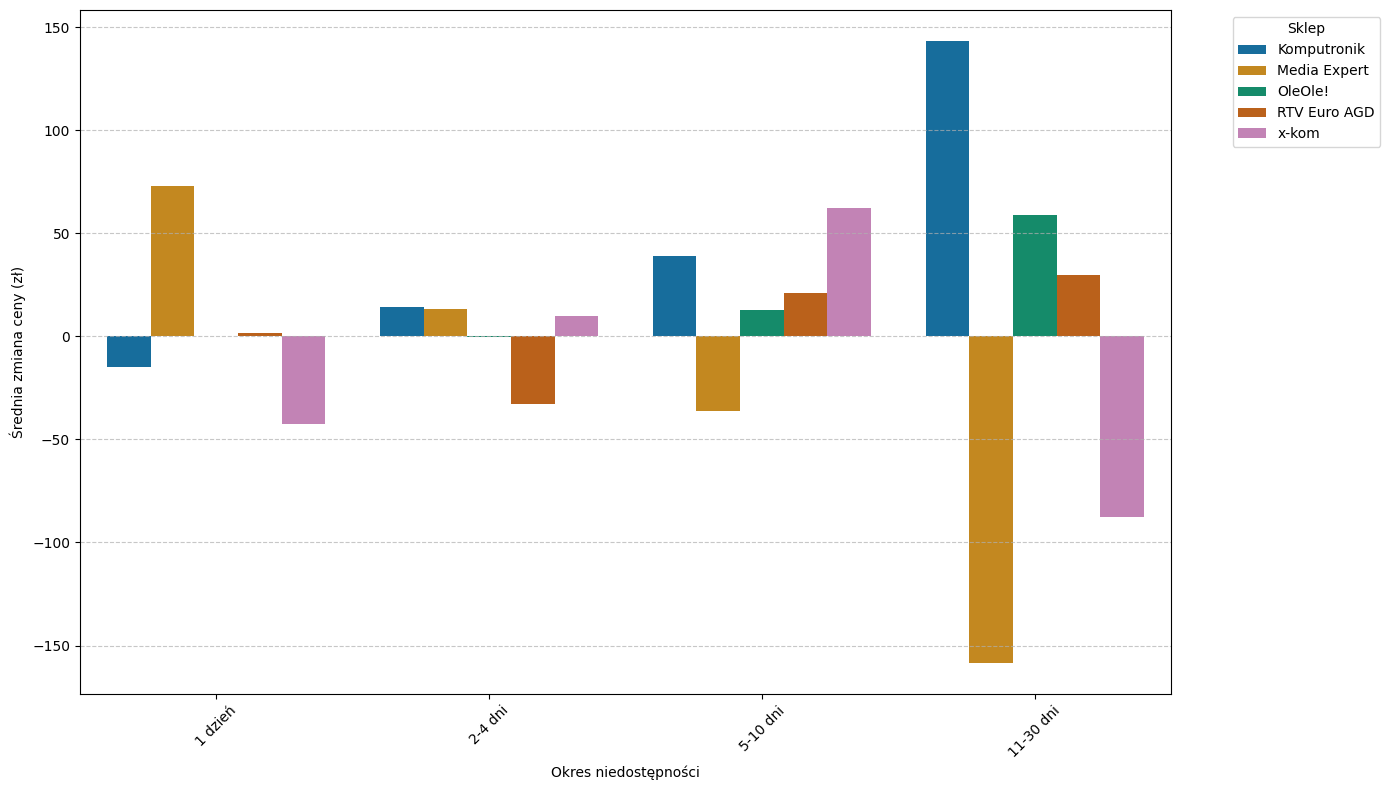

C:\Users\kryst\AppData\Local\Temp\ipykernel_18172\338424292.py:109: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  final_result_grouped = final_result.groupby(['Sklep', 'Okres', 'Typ zmiany']).size().reset_index(name='Liczba zmian')
C:\Users\kryst\AppData\Local\Temp\ipykernel_18172\338424292.py:112: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_data = final_result_grouped.pivot_table(index=['Sklep', 'Okres'], columns='Typ zmiany', values='Liczba zmian', aggfunc='sum').fillna(0)
C:\Users\kryst\AppData\Local\Temp\ipykernel_18172\338424292.py:117: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and

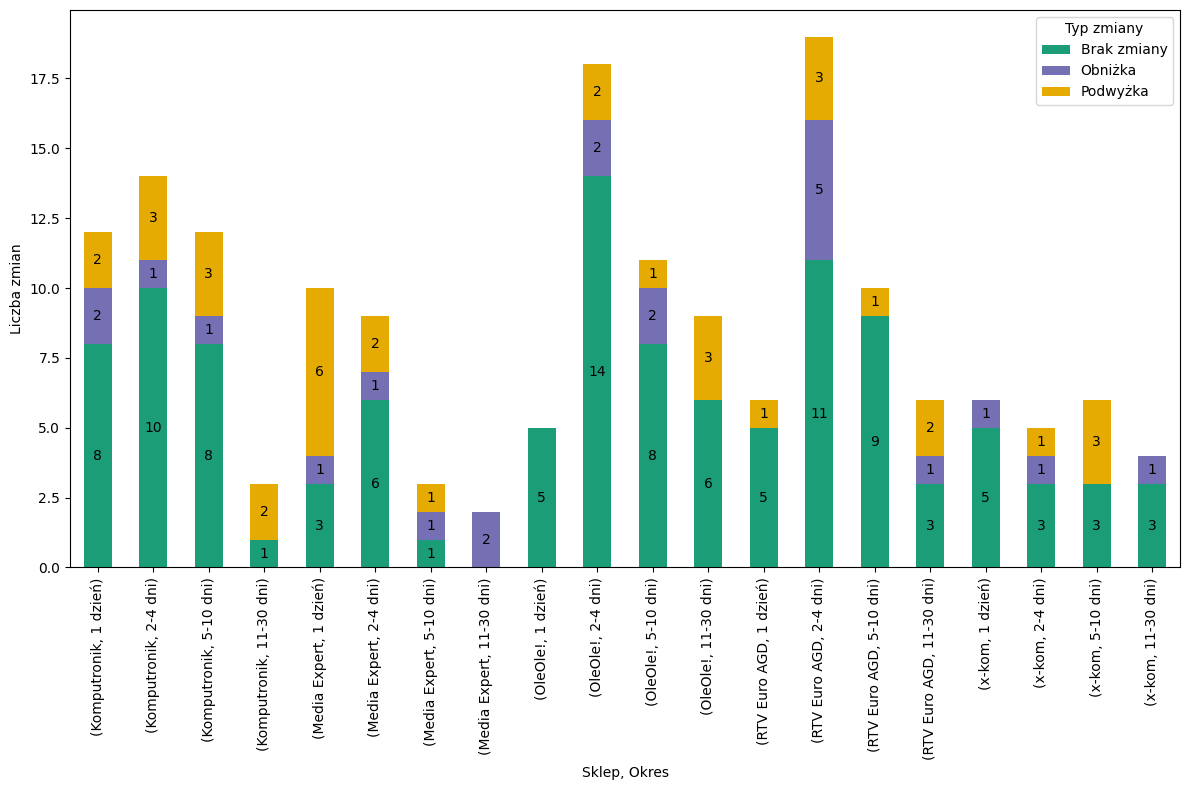

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Wczytanie danych
df = pd.read_csv('monitoring_cen.csv')
df['Data'] = pd.to_datetime(df['Data'])

# Sortowanie danych po urządzeniu, sklepie i dacie
df = df.sort_values(by=['Nazwa urzadzenia', 'Sklep', 'Data'])

# Tworzenie nowej kolumny 'Grupa' w DataFrame, która grupuje kolejne okresy dostępności
df['Grupa'] = (df['Czy dostepny'] != df['Czy dostepny'].shift()).cumsum()

# Filtrowanie danych, aby uzyskać tylko te wiersze, w których produkt jest dostępny
df_available = df[df['Czy dostepny'] == 1]

def avability_price(df, df_available, number_days_1, number_days_2):
    # Odpowiednie dodanie dnia aby liczyło okresy
    number_days_1 = number_days_1 + 1  
    number_days_2 = number_days_2 + 1
    periods = []
    
    # Grupowanie danych na podstawie 'Nazwa urzadzenia' i 'Sklep'
    for (device, store), group in df_available.groupby(['Nazwa urzadzenia', 'Sklep']):
        for i in range(1, len(group)):
            # Sprawdzanie, czy różnica dni między kolejnymi dostępnościami mieści się w podanym zakresie
            if number_days_1 <= (group.iloc[i]['Data'] - group.iloc[i - 1]['Data']).days <= number_days_2:
                # Pobieranie danych dla ostatniego dnia przed niedostępnością
                last_day_before = df[
                    (df['Nazwa urzadzenia'] == device) &
                    (df['Sklep'] == store) &
                    (df['Data'] == group.iloc[i - 1]['Data'])
                ]
                
                if not last_day_before.empty:
                    # Cena przed niedostępnością
                    price_before = last_day_before['Cena (zł)'].values[0]
                    # Pierwszy dzień po dostępności
                    first_day_after = group.iloc[i]['Data']
                    # Cena po dostępności
                    price_after = group.iloc[i]['Cena (zł)']
                    # Zmiana ceny
                    change_price = price_after - price_before

                    # Dodanie okresu zmiany ceny do listy periods
                    periods.append((device, store, group.iloc[i - 1]['Data'], price_before,
                                    first_day_after, price_after, change_price))
    
    # Tworzenie ramki danych
    return pd.DataFrame(periods, columns=[
        'Nazwa urzadzenia', 'Sklep', 'Data ostatniego dnia przed niedostępnością',
        'Cena w dzień przed niedostępnością', 'Data pierwszego dnia po dostępności',
        'Cena w dzień po niedostępności', 'Zmiana ceny'
    ])


# Zakresy okresów niedostępności do analizy
categories = [(1, 1), (2, 4), (5, 10), (11, 30)]
category_labels = ["1 dzień", "2-4 dni", "5-10 dni", "11-30 dni"]

results = []

# Analiza dla każdego zakresu dni
for (start, end), label in zip(categories, category_labels):
    result_df = avability_price(df, df_available, start, end)
    result_df['Okres'] = label
    results.append(result_df)

# Połączenie wyników dla różnych kategorii
final_result = pd.concat(results)

# Ustawienie kolejności kategorii w kolumnie 'Okres'
final_result['Okres'] = pd.Categorical(
    final_result['Okres'], 
    categories=["1 dzień", "2-4 dni", "5-10 dni", "11-30 dni"],
    ordered=True
)

# Grupowanie i analiza po sklepach i kategoriach z uwzględnieniem liczby sytuacji
grouped = final_result.groupby(['Sklep', 'Okres']).agg(
    average_price_change=('Zmiana ceny', 'mean'),
    count=('Zmiana ceny', 'size'),  # Liczba sytuacji
    number_of_price_increases=('Zmiana ceny', lambda x: (x > 0).sum()),
    number_of_price_discounts=('Zmiana ceny', lambda x: (x < 0).sum()),
    percentage_increase_in_price=('Zmiana ceny', lambda x: (x > 0).mean() * 100)
).reset_index()

# Wizualizacja: Średnia zmiana ceny po sklepach i okresach z liczbą sytuacji
plt.figure(figsize=(14, 8))
ax = sns.barplot(
    x='Okres', y='average_price_change', hue='Sklep', data=grouped, palette='colorblind'
)


# Formatowanie wykresu
#plt.title('Średnia zmiana ceny po niedostępności w sklepach dla różnych okresów (z liczbą sytuacji)')
plt.xlabel('Okres niedostępności')
plt.ylabel('Średnia zmiana ceny (zł)')
plt.legend(title='Sklep', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Dodanie kolumny z typem zmiany
final_result['Typ zmiany'] = final_result['Zmiana ceny'].apply(lambda x: 'Podwyżka' if x > 0 else ('Obniżka' if x < 0 else 'Brak zmiany'))

# Grupowanie
final_result_grouped = final_result.groupby(['Sklep', 'Okres', 'Typ zmiany']).size().reset_index(name='Liczba zmian')

# Tworzenie tabeli przestawnej
pivot_data = final_result_grouped.pivot_table(index=['Sklep', 'Okres'], columns='Typ zmiany', values='Liczba zmian', aggfunc='sum').fillna(0)

import matplotlib.cm as cm

# mapa kolorów
colormap = cm.get_cmap('Dark2')  # Możesz zmienić na inne, np. 'plasma', 'coolwarm', 'rainbow'

# Liczba różnych typów zmian (liczba słupków w grupie)
number_types = len(pivot_data.columns)

# Tworzenie listy kolorów dla każdego typu
colors = [colormap(i / number_types) for i in range(number_types)]

# Tworzenie wykresu z przypisaniem kolorów
ax = pivot_data.plot(kind='bar', stacked=True, figsize=(12, 8), color=colors)

# Dodanie etykiet z liczbą zmian na słupkach
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{int(height)}', 
                    (p.get_x() + p.get_width() / 2., p.get_height() + p.get_y() - (0.5 * p.get_height())),
                    ha='center', va='center', fontsize=10)

# Ustawienie tytułów i etykiet
#plt.title('Liczba zmian typu zmiany w sklepach w danym okresie')
plt.xlabel('Sklep, Okres')
plt.ylabel('Liczba zmian')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


6. Czy istnieją konkurujące ze sobą sklepy, które mają podobne strategie?

Sklep         Komputronik  Media Expert   OleOle!  RTV Euro AGD     x-kom
Sklep                                                                    
Komputronik      1.000000      0.995877  0.943961      0.944141  0.996472
Media Expert     0.995877      1.000000  0.934781      0.934419  0.996803
OleOle!          0.943961      0.934781  1.000000      0.999728  0.949193
RTV Euro AGD     0.944141      0.934419  0.999728      1.000000  0.948748
x-kom            0.996472      0.996803  0.949193      0.948748  1.000000


C:\Users\kryst\AppData\Local\Temp\ipykernel_19196\1896512966.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(labels, (df_pca['PC1'][i], df_pca['PC2'][i]))


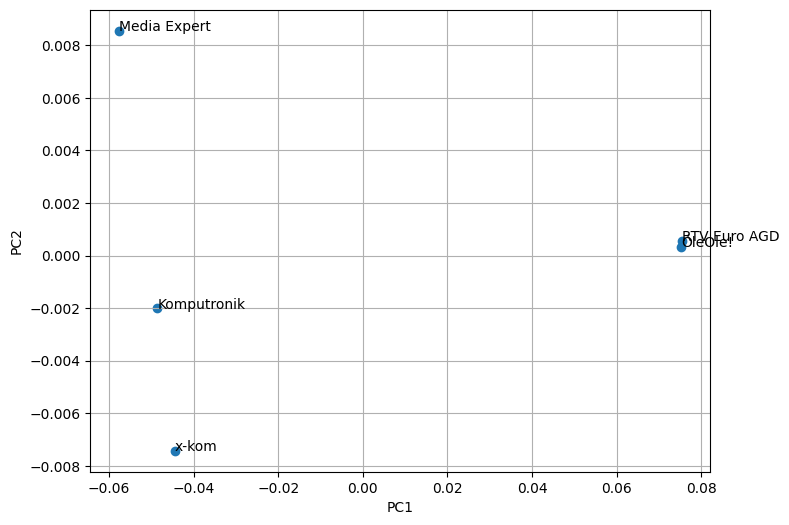

C:\Users\kryst\AppData\Local\Temp\ipykernel_19196\1896512966.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(df_pca['PC1'][i], df_pca['PC2'][i], df_pca['PC3'][i], txt, size=10)


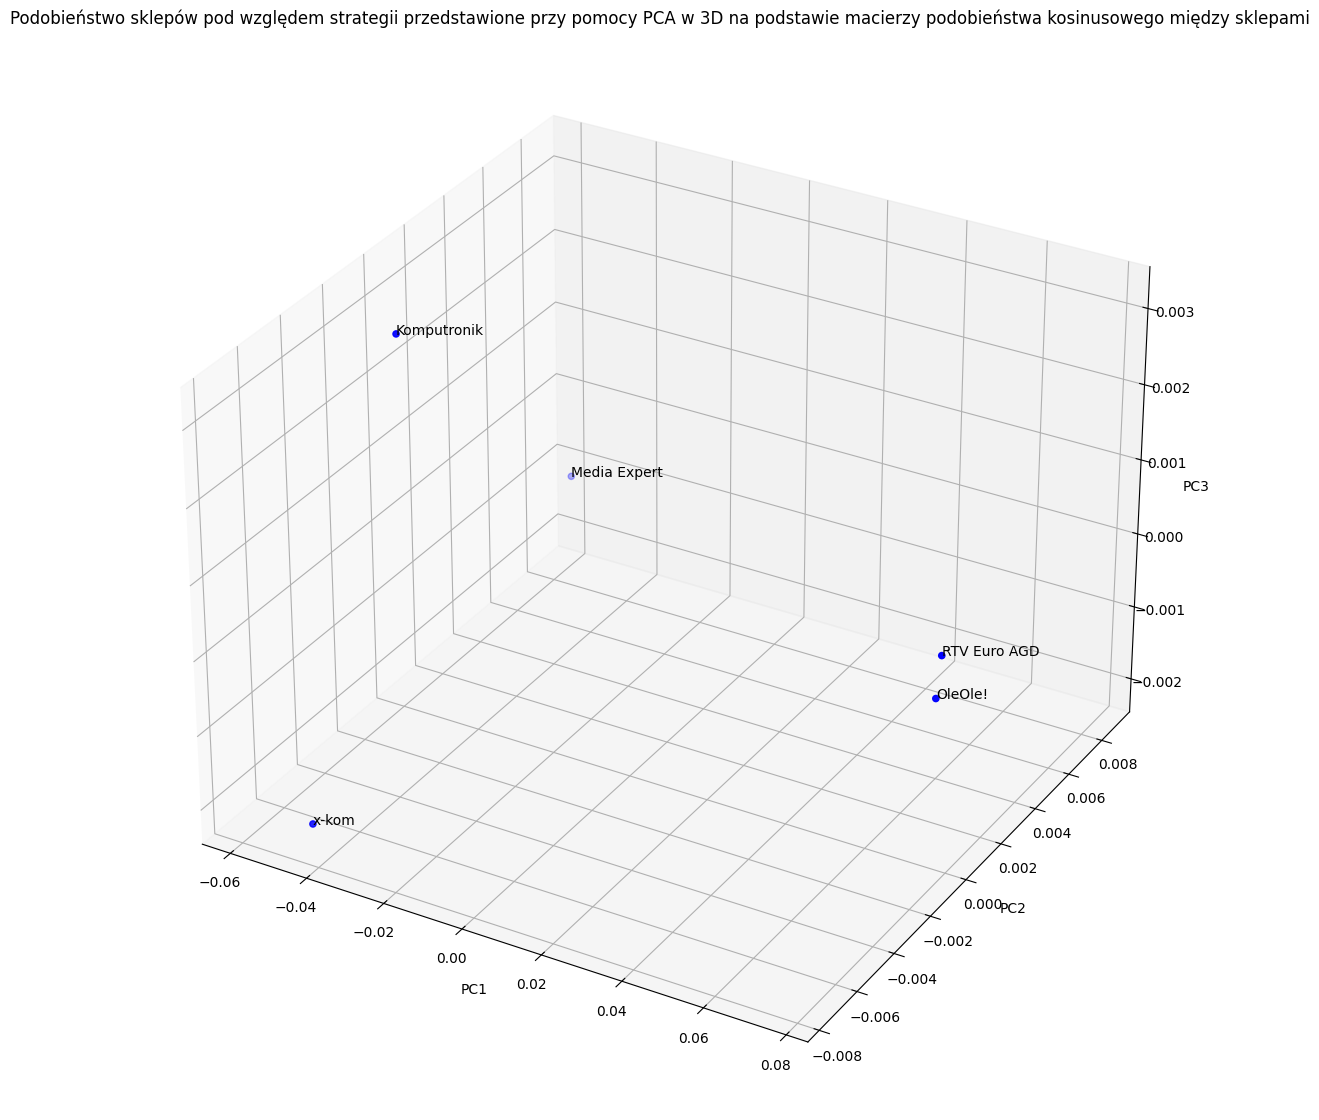

In [9]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Wczytanie danych
df = pd.read_csv('monitoring_cen.csv')
df['Data'] = pd.to_datetime(df['Data'])

# Sortowanie danych po urządzeniu, sklepie i dacie
df = df.sort_values(by=['Nazwa urzadzenia', 'Sklep', 'Data'])

# Dodanie kolumn dotyczących zmian cen, ich typów i dostepności
df['Zmiana dostepnosci'] = df.groupby(['Nazwa urzadzenia', 'Sklep'])['Czy dostepny'].diff()
df['Zmiana ceny'] = df.groupby(['Sklep', 'Nazwa urzadzenia'])['Cena (zł)'].diff()
df['Podwyzka'] = df['Zmiana ceny'].apply(lambda x: 1 if x > 0 else 0)
df['Obnizka'] = df['Zmiana ceny'].apply(lambda x: 1 if x < 0 else 0)


# Tabele przestawne dla analizy strategii cenowych, dostępności i zmian
pivot_prices = df.pivot_table(index='Sklep', columns='Nazwa urzadzenia', values='Cena (zł)', aggfunc='mean')
pivot_availability = df.pivot_table(index='Sklep', columns='Nazwa urzadzenia', values='Czy dostepny', aggfunc='mean')
pivot_price_change = df.pivot_table(index='Sklep', columns='Nazwa urzadzenia', values='Zmiana ceny', aggfunc='mean')
pivot_availability_change = df.pivot_table(index='Sklep', columns='Nazwa urzadzenia', values='Zmiana dostepnosci', aggfunc='mean')
pivot_increase = df.pivot_table(index='Sklep', columns='Nazwa urzadzenia', values='Podwyzka', aggfunc='count')
pivot_discount = df.pivot_table(index='Sklep', columns='Nazwa urzadzenia', values='Obnizka', aggfunc='count')

# Połączenie tabeli przestawnych
pivot_data = pd.concat([pivot_prices, pivot_availability, pivot_price_change, pivot_availability_change, pivot_increase, pivot_discount], axis=1)

# Uzupełnienie pustych wartości 0
pivot_data = pivot_data.fillna(0)

# Stworzenie macierzy podobieństwa kosinusowego
cosine_similarity_matrix = cosine_similarity(pivot_data)

# Zamiana macierzy na ramkę danych
cosine_similarity_df = pd.DataFrame(
    cosine_similarity_matrix, 
    index=pivot_data.index, 
    columns=pivot_data.index
)

# Wyświetlenie macierzy podobieństwa
print(cosine_similarity_df)

# Tworzenie macierzy z ramki danych
similarity_matrix = pd.DataFrame(cosine_similarity_df, index=['Komputronik', 'Media Expert', 'OleOle!', 'RTV Euro AGD', 'x-kom'])

# Zastosowanie PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(similarity_matrix)

# Tworzenie ramki danych z wynikami PCA
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'], index=similarity_matrix.index)

# Wizualizacja
plt.figure(figsize=(8, 6))
plt.scatter(df_pca['PC1'], df_pca['PC2'])

# Dodanie etykiet sklepów do wykresu
for i, labels in enumerate(df_pca.index):
    plt.annotate(labels, (df_pca['PC1'][i], df_pca['PC2'][i]))

#plt.title('PCA na podstawie macierzy podobieństwa kosinusowego między sklepami')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.show()


# Zastosowanie PCA z 3 komponentami
pca = PCA(n_components=3)
principal_components = pca.fit_transform(similarity_matrix)

# Tworzenie ramki dnaych z wynikami PCA
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'], index=similarity_matrix.index)

# Wizualizacja w trzech wymiarach
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_pca['PC1'], df_pca['PC2'], df_pca['PC3'], color='b')

# Dodanie etykiet sklepów do wykresu
for i, txt in enumerate(df_pca.index):
    ax.text(df_pca['PC1'][i], df_pca['PC2'][i], df_pca['PC3'][i], txt, size=10)

ax.set_title('Podobieństwo sklepów pod względem strategii przedstawione przy pomocy PCA w 3D na podstawie macierzy podobieństwa kosinusowego między sklepami')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.show()
